# Project: Smartphone Data Analysis

In [239]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## Association Rules

In [240]:
def assoc_rules(data, m_sup, m_thr):

    te = TransactionEncoder()
    te_data = te.fit(data).transform(data)
    pr = pd.DataFrame(te_data,columns=te.columns_)

    # Apriori function to extract frequent itemsets for association rule mining
    # Support threshold can be mentioned to retrieve frequent itemset
    freq_items = apriori(pr, min_support = m_sup, use_colnames = True, verbose = 1)

    # Association rule mining
    #Let's view our interpretation values using the Association rule function.
    #Function to generate association rules from frequent itemsets
    pr_ar = association_rules(freq_items, metric = "confidence", min_threshold = m_thr)
    return freq_items, pr_ar

## KMeans Algorithm/Clustering

In [241]:
def rsserr(a,b):
    '''
    Calculate the root of sum of squared errors. 
    a and b are numpy arrays
    '''
    return np.square(np.sum((a-b)**2))

def initiate_centroids(k, dset):
    '''
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    '''
    centroids = dset.sample(k)
    return centroids

def centroid_assignation(dset, centroids):
    '''
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid. 
    - dset - pandas dataframe with observations
    - centroids - pa das dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

def kmeans(dset, k=2, tol=1e-4):
    '''
    K-means implementationd for a 
    `dset`:  DataFrame with observations
    `k`: number of clusters, default k=2
    `tol`: tolerance=1E-4
    '''
    # Let us work in a copy, so we don't mess the original
    working_dset = dset.copy()
    # We define some variables to hold the error, the 
    # stopping signal and a counter for the iterations
    err = []
    goahead = True
    j = 0
    
    # Step 2: Initiate clusters by defining centroids 
    centroids = initiate_centroids(k, dset)

    while(goahead):
        # Step 3 and 4 - Assign centroids and calculate error
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids) 
        err.append(sum(j_err))
        
        # Step 5 - Update centroid position
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

        # Step 6 - Restart the iteration
        if j>0:
            # Is the error less than a tolerance (1E-4)
            if err[j-1]-err[j]<=tol:
                goahead = False
        j+=1

    working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    return working_dset['centroid'], j_err, centroids

## My Functions

In [242]:
# Function to convert Indian Rupees to Euros and round to 2 decimal places
def inr_to_euro(price_inr, exchange_rate=0.011):
    price_inr = float(price_inr.replace('₹', '').replace(',', '').strip())
    price_euro = price_inr * exchange_rate
    return round(price_euro, 2)

# Function to extract the required information for processor column
def extract_processor_info(processor):
    parts = processor.split(',')  # Split the string by comma

    # Remove the word "Processor" if found in any part
    cleaned_parts = []
    for part in parts:
        cleaned_part = part.replace('Processor', '').strip()
        cleaned_parts.append(cleaned_part)
    parts = cleaned_parts
    
    processor_type = parts[0].strip()
    # if there is a second part, extract the core type
    if len(parts) > 1:
        core_type = parts[1].strip()
    else:
        core_type = 'N/A'
    # if there is a third part, extract the clock speed
    if len(parts) > 2:
        clock_speed = parts[2].strip()
    else:
        clock_speed = 'N/A'
    return processor_type, core_type, clock_speed

def one_hot_enco_proc(df):
    # Extract information into a list of tuples
    data = []
    for p in df['processor']:
        info = extract_processor_info(p)
        data.append(info)

    # Create DataFrame
    df_proc = pd.DataFrame(data, columns=['processor_type', 'core_type', 'clock_speed'])

    # Remove any additional spaces around the processor_type
    df_proc['processor_type'] = df_proc['processor_type'].str.strip().str.replace('  ', ' ')

    # Add the extracted columns to the original DataFrame
    df[['processor_type', 'core_type', 'clock_speed']] = df_proc

    # Convert columns to integer codes 
    df['processor_type_code'] = pd.factorize(df['processor_type'])[0] # [0]: Return the codes [1]: Return the unique values
    df['core_type_code'] = pd.factorize(df['core_type'])[0]
    df['clock_speed_code'] = pd.factorize(df['clock_speed'])[0]
    return df

## Dataset

In [243]:
# Read the dataset
df = pd.read_csv('/Users/frottori/Documents/Code/Python/Big_Data_Python/Datasets/smartphones - smartphones.csv')
# Add a new column 'Price_Euro' with the converted prices as the third column
df.insert(2, 'Price_Euro', df['price'].apply(inr_to_euro))
# Show first 10 entries from dataset 
df.head(10)

,model,price,Price_Euro,rating,sim,processor,ram,battery,display,camera,card,os
0,OnePlus 11 5G,"₹54,999",604.99,89.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8 Gen2, Octa Core, 3.2 GHz Processor","12 GB RAM, 256 GB inbuilt",5000 mAh Battery with 100W Fast Charging,"6.7 inches, 1440 x 3216 px, 120 Hz Display wit...",50 MP + 48 MP + 32 MP Triple Rear & 16 MP Fron...,Memory Card Not Supported,Android v13
1,OnePlus Nord CE 2 Lite 5G,"₹19,989",219.88,81.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Snapdragon 695, Octa Core, 2.2 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with 33W Fast Charging,"6.59 inches, 1080 x 2412 px, 120 Hz Display wi...",64 MP + 2 MP + 2 MP Triple Rear & 16 MP Front ...,"Memory Card (Hybrid), upto 1 TB",Android v12
2,Samsung Galaxy A14 5G,"₹16,499",181.49,75.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Exynos 1330, Octa Core, 2.4 GHz Processor","4 GB RAM, 64 GB inbuilt",5000 mAh Battery with 15W Fast Charging,"6.6 inches, 1080 x 2408 px, 90 Hz Display with...",50 MP + 2 MP + 2 MP Triple Rear & 13 MP Front ...,"Memory Card Supported, upto 1 TB",Android v13
3,Motorola Moto G62 5G,"₹14,999",164.99,81.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Snapdragon 695, Octa Core, 2.2 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with Fast Charging,"6.55 inches, 1080 x 2400 px, 120 Hz Display wi...",50 MP + 8 MP + 2 MP Triple Rear & 16 MP Front ...,"Memory Card (Hybrid), upto 1 TB",Android v12
4,Realme 10 Pro Plus,"₹24,999",274.99,82.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Dimensity 1080, Octa Core, 2.6 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with 67W Fast Charging,"6.7 inches, 1080 x 2412 px, 120 Hz Display wit...",108 MP + 8 MP + 2 MP Triple Rear & 16 MP Front...,Memory Card Not Supported,Android v13
5,Samsung Galaxy F23 5G (6GB RAM + 128GB),"₹16,999",186.99,80.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 750G, Octa Core, 2.2 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with 25W Fast Charging,"6.6 inches, 1080 x 2408 px, 120 Hz Display wit...",50 MP + 8 MP + 2 MP Triple Rear & 8 MP Front C...,"Memory Card Supported, upto 1 TB",Android v12
6,Apple iPhone 14,"₹65,999",725.99,81.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Bionic A15, Hexa Core, 3.22 GHz Processor","6 GB RAM, 128 GB inbuilt",3279 mAh Battery with Fast Charging,"6.1 inches, 1170 x 2532 px Display with Small ...",12 MP + 12 MP Dual Rear & 12 MP Front Camera,Memory Card Not Supported,iOS v16
7,Xiaomi Redmi Note 12 Pro Plus,"₹29,999",329.99,86.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, IR Blaster","Dimensity 1080, Octa Core, 2.6 GHz Processor","8 GB RAM, 256 GB inbuilt",4980 mAh Battery with 120W Fast Charging,"6.67 inches, 1080 x 2400 px, 120 Hz Display wi...",200 MP + 8 MP + 2 MP Triple Rear & 16 MP Front...,Memory Card Not Supported,Android v12
8,Nothing Phone 1,"₹26,749",294.24,85.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 778G Plus, Octa Core, 2.5 GHz Proce...","8 GB RAM, 128 GB inbuilt",4500 mAh Battery with 33W Fast Charging,"6.55 inches, 1080 x 2400 px, 120 Hz Display wi...",50 MP + 50 MP Dual Rear & 16 MP Front Camera,Android v12,No FM Radio
9,OnePlus Nord 2T 5G,"₹28,999",318.99,84.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Dimensity 1300, Octa Core, 3 GHz Processor","8 GB RAM, 128 GB inbuilt",4500 mAh Battery with 80W Fast Charging,"6.43 inches, 1080 x 2400 px, 90 Hz Display wit...",50 MP + 8 MP + 2 MP Triple Rear & 32 MP Front ...,Android v12,No FM Radio


## 1. Price - Processor
### Cluster Analysis - kMeans Algorithm

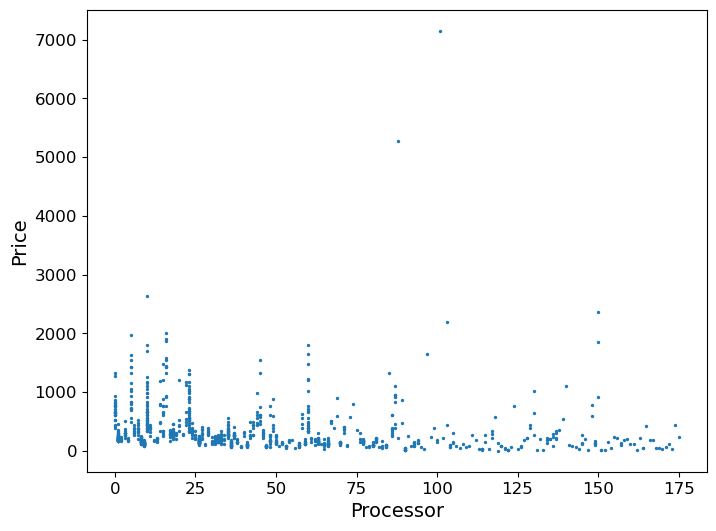

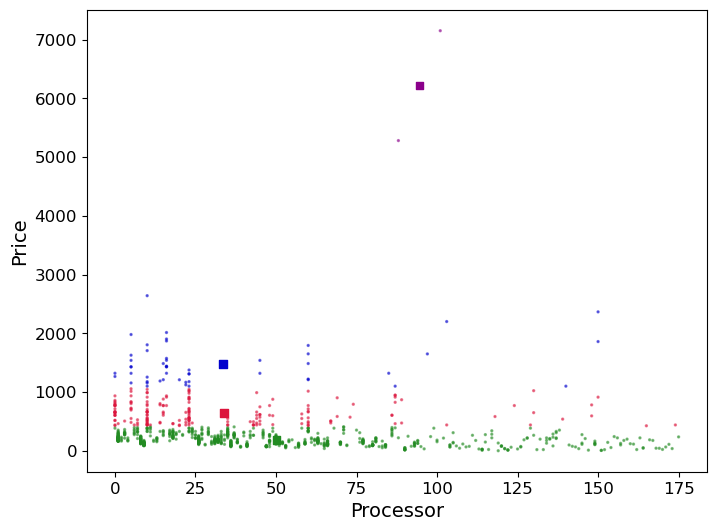

,model,Price_Euro,processor,processor_type_code,core_type_code,clock_speed_code,centroid,error
0,OnePlus 11 5G,604.99,"Snapdragon 8 Gen2, Octa Core, 3.2 GHz Processor",0,0,0,0,8.371468e+06
1,OnePlus Nord CE 2 Lite 5G,219.88,"Snapdragon 695, Octa Core, 2.2 GHz Processor",1,0,1,3,1.192683e+07
2,Samsung Galaxy A14 5G,181.49,"Exynos 1330, Octa Core, 2.4 GHz Processor",2,0,2,3,5.556286e+06
3,Motorola Moto G62 5G,164.99,"Snapdragon 695, Octa Core, 2.2 GHz Processor",1,0,1,3,8.589521e+06
4,Realme 10 Pro Plus,274.99,"Dimensity 1080, Octa Core, 2.6 GHz Processor",3,0,3,3,9.697981e+07
5,Samsung Galaxy F23 5G (6GB RAM + 128GB),186.99,"Snapdragon 750G, Octa Core, 2.2 GHz Processor",4,0,1,3,4.540263e+06
6,Apple iPhone 14,725.99,"Bionic A15, Hexa Core, 3.22 GHz Processor",5,1,4,0,5.042157e+07
7,Xiaomi Redmi Note 12 Pro Plus,329.99,"Dimensity 1080, Octa Core, 2.6 GHz Processor",3,0,3,3,5.052454e+08
8,Nothing Phone 1,294.24,"Snapdragon 778G Plus, Octa Core, 2.5 GHz Proce...",6,0,5,3,1.770537e+08
9,OnePlus Nord 2T 5G,318.99,"Dimensity 1300, Octa Core, 3 GHz Processor",7,0,6,3,3.650566e+08


In [244]:
def price_processor_analysis(df):
    # Scatter plot of the data points
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.scatter(x=df['processor_type_code'], y=df['Price_Euro'], s=2)
    ax.set_xlabel(r'Processor', fontsize=14)
    ax.set_ylabel(r'Price', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    # Apply the k-means algorithm to the dataset
    np.random.seed(42)  # Set seed to 42 for reproducibility
    k = 4               # Number of clusters (for low range processors, medium range processors, and high range processors)
    df['centroid'], df['error'], centroids =  kmeans(df[['processor_type_code','Price_Euro']], k)

    # Colors for the clusters in the scatter plot
    customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta", "forestgreen"])
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.scatter(x=df['processor_type_code'], y=df['Price_Euro'],  marker = 'o', 
                c=df['centroid'].astype('category'), 
                cmap = customcmap, s=2, alpha=0.5)
    plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
                marker = 's', s=30, c=[0, 1, 2, 3], 
                cmap = customcmap)
    ax.set_xlabel(r'Processor', fontsize=14)
    ax.set_ylabel(r'Price', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    return df

# Map the processor categories to integers using one-hot encoding (same processor type will have the same code)
df = one_hot_enco_proc(df)
df = price_processor_analysis(df)
# Display data after clustering
df[['model','Price_Euro','processor','processor_type_code','core_type_code','clock_speed_code','centroid','error']].head(10)

### Association Rule Mining for each cluster

In [245]:
def assoc_mining_proc(df, c, min_sup=0.2, min_thr=0.6):
    df = df[df['centroid'] == c]
    # Dataframe with all processor characteristics
    pr = pd.DataFrame(df['processor']);
    # Remove the thin space character
    pr = pr.replace('\u2009', '', regex=True)
    data = list(pr["processor"].apply(lambda x:x.split(",") ))

    freq_items, pr_ar = assoc_rules(data, min_sup, min_thr)
    return freq_items, pr_ar

### Low-End phones

##### Frequent Items

In [246]:
freq_items3, pr_ar3 = assoc_mining_proc(df, 3, 0.1, 0.1)
freq_items3.head()

Processing 20 combinations | Sampling itemset size 2


,support,itemsets
0,0.169427,( 2.2GHz Processor)
1,0.109554,( 2.3GHz Processor)
2,0.157962,( 2.4GHz Processor)
3,0.185987,( 2GHz Processor)
4,0.871338,( Octa Core)


##### Association Rules

In [247]:
pr_ar3.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( Octa Core),( 2.2GHz Processor),0.871338,0.169427,0.168153,0.192982,1.139032,0.020525,1.029189,0.948695
1,( 2.2GHz Processor),( Octa Core),0.169427,0.871338,0.168153,0.992481,1.139032,0.020525,17.112102,0.146960
2,( Octa Core),( 2.3GHz Processor),0.871338,0.109554,0.109554,0.125731,1.147661,0.014096,1.018503,1.000000
3,( 2.3GHz Processor),( Octa Core),0.109554,0.871338,0.109554,1.000000,1.147661,0.014096,inf,0.144492
4,( 2.4GHz Processor),( Octa Core),0.157962,0.871338,0.157962,1.000000,1.147661,0.020324,inf,0.152799


### Mid-Range phones

##### Frequent Items

In [248]:
freq_items0, pr_ar0 = assoc_mining_proc(df, 0, 0.1, 0.1)
freq_items0.head()

Processing 4 combinations | Sampling itemset size 43


,support,itemsets
0,0.311475,( 3.2GHz Processor)
1,0.158470,( 3GHz Processor)
2,0.109290,( Hexa Core)
3,0.825137,( Octa Core)
4,0.114754,(Snapdragon 8 Gen2)


##### Association Rules

In [249]:
pr_ar0.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 3.2GHz Processor),( Octa Core),0.311475,0.825137,0.311475,1.000000,1.211921,0.054466,inf,0.253968
1,( Octa Core),( 3.2GHz Processor),0.825137,0.311475,0.311475,0.377483,1.211921,0.054466,1.106034,1.000000
2,( 3.2GHz Processor),(Snapdragon 8 Gen2),0.311475,0.114754,0.114754,0.368421,3.210526,0.079011,1.401639,1.000000
3,(Snapdragon 8 Gen2),( 3.2GHz Processor),0.114754,0.311475,0.114754,1.000000,3.210526,0.079011,inf,0.777778
4,( 3.2GHz Processor),(Snapdragon 8+ Gen1),0.311475,0.114754,0.114754,0.368421,3.210526,0.079011,1.401639,1.000000


### High-End phones

##### Frequent Items

In [250]:
freq_items1, pr_ar1 = assoc_mining_proc(df, 1, 0.1, 0.1)
freq_items1.head()

Processing 33 combinations | Sampling itemset size 3


,support,itemsets
0,0.14,( 2.84GHz Processor)
1,0.14,( 3.22GHz Processor)
2,0.20,( 3.2GHz Processor)
3,0.10,( 3GHz Processor)
4,0.20,( Hexa Core)


##### Association Rules

In [251]:
pr_ar1.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 2.84GHz Processor),( Octa Core),0.14,0.58,0.14,1.000000,1.724138,0.0588,inf,0.488372
1,( Octa Core),( 2.84GHz Processor),0.58,0.14,0.14,0.241379,1.724138,0.0588,1.133636,1.000000
2,( Hexa Core),( 3.22GHz Processor),0.20,0.14,0.14,0.700000,5.000000,0.1120,2.866667,1.000000
3,( 3.22GHz Processor),( Hexa Core),0.14,0.20,0.14,1.000000,5.000000,0.1120,inf,0.930233
4,(Bionic A15),( 3.22GHz Processor),0.14,0.14,0.14,1.000000,7.142857,0.1204,inf,1.000000


### Very High-End phones (Luxury phones)

##### Frequent Items

In [252]:
freq_items2, pr_ar2 = assoc_mining_proc(df, 2, 0.1, 0.1)
freq_items2.head()

Processing 4 combinations | Sampling itemset size 43


,support,itemsets
0,0.5,( 1.5GHz Processor)
1,0.5,( 2.8GHz Processor)
2,1.0,( Octa Core)
3,0.5,(Snapdragon 855)
4,0.5,(Snapdragon 801)


##### Association Rules

In [253]:
pr_ar2.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 1.5GHz Processor),( Octa Core),0.5,1.0,0.5,1.0,1.0,0.00,inf,0.0
1,( Octa Core),( 1.5GHz Processor),1.0,0.5,0.5,0.5,1.0,0.00,1.0,0.0
2,( 1.5GHz Processor),(Snapdragon 801),0.5,0.5,0.5,1.0,2.0,0.25,inf,1.0
3,(Snapdragon 801),( 1.5GHz Processor),0.5,0.5,0.5,1.0,2.0,0.25,inf,1.0
4,( 2.8GHz Processor),( Octa Core),0.5,1.0,0.5,1.0,1.0,0.00,inf,0.0


## 2. Price - RAM